## Import Libraries

In [39]:
import pickle
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Visualization functions

In [40]:
def plot_roc_curve(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
def plot_confusion_matrix(model, X_test, y_test):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot()
    plt.show()
def calculate_featuer_importances(model, X_Cols):
    feature_imp = pd.Series(model.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
    return feature_imp

## Preproces function

In [41]:
def column_name_preprocesing(df):
    df = df.copy()
    df.rename(columns={'<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'volume', '<TICKER>':'symbol','<DATE>':'datetime'}, inplace=True)
    columns_to_keep = ['symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume']
    df = df[columns_to_keep]
    df.sort_values(by = ['symbol','datetime'], inplace = True)
    df['change_in_price'] = df['close'].diff()
    return df

## Indicators functions

In [42]:
def rsi(df, n = 14):
    df = df.copy()
    up_df, down_df = df[['symbol','change_in_price']].copy(), df[['symbol','change_in_price']].copy()
    up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    relative_strength = ewma_up / ewma_down
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
    df[f'down_days_{n}'] = down_df['change_in_price']
    df[f'up_days_{n}'] = up_df['change_in_price']
    df[f'RSI_{n}'] = relative_strength_index
    return df

def stochastic_oscillator(df, n = 14):
    df = df.copy()
    low_n, high_n = df[['symbol','low']].copy(), df[['symbol','high']].copy()
    low_n = low_n.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())
    k_percent = 100 * ((df['close'] - low_n) / (high_n - low_n))
    df[f'low_{n}'] = low_n
    df[f'high_{n}'] = high_n
    df[f'k_percent_{n}'] = k_percent
    return df

def williams_percent_r(df, n =14):
    df = df.copy()
    low_n, high_n = df[['symbol','low']].copy(), df[['symbol','high']].copy()
    low_n = low_n.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_n = high_n.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())
    r_percent = ((high_n - df['close']) / (high_n - low_n)) * - 100
    df[f'r_percent_{n}'] = r_percent
    return df

def macd(df):
    df = df.copy()
    ema_26 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span = 9).mean()
    df['MACD'] = macd
    df['MACD_EMA'] = ema_9_macd
    return df

def price_rate(df, n = 9):
    df = df.copy()
    df[f'Price_Rate_Of_Change_{n}'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))
    return df

def obv(df):
    df = df.copy()
    volume = df['volume']
    change = df['close'].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    df['on_balance_volume'] = pd.Series(obv_values, index = df.index)
    return df

## Main part

### Open Files

In [43]:
folder_path = './data/'
files = os.listdir(folder_path)
print(files)

list_to_concat = []
for file in files[:6]:
    if 'txt' in file:
        list_to_concat.append(pd.read_csv(f'./data/{file}', sep=','))

['AFKS_daily_010114_010124.csv', 'AFKS_daily_010114_010124.txt', 'AFLT_daily_010114_010124.csv', 'AFLT_daily_010114_010124.txt', 'to_predict']


In [44]:
result = pd.concat(list_to_concat, ignore_index=True)
result = column_name_preprocesing(result)
mask = result['symbol'] != result['symbol'].shift(1)
result['change_in_price'] = np.where(mask == True, np.nan, result['change_in_price'])
(result[result.isna().any(axis = 1)]).shape[0]


2

### Indicators calculation

In [45]:
df = result
df = rsi(df)
df = stochastic_oscillator(df)
df = williams_percent_r(df)
df = macd(df)
df = price_rate(df)
df = obv(df)
price_data = df

### Target

In [46]:
close_groups = price_data.groupby('symbol')['close']
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))
price_data['target'] = close_groups
price_data['target'] = df['target'].replace(0, -1)

### Drop NaNs

In [47]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data = price_data.dropna()
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

Before NaN Drop we have 5006 rows and 20 columns
After NaN Drop we have 4980 rows and 20 columns


### Train-test split

In [48]:
X_Cols = price_data.drop(['MACD_EMA', 'symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume', 
                          'change_in_price', 'down_days_14', 'up_days_14', 'low_14', 'high_14','target'], axis = 1)

Y_Cols = price_data['target']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

## Fit Models

### Random Forest

In [49]:
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf.fit(X_train, y_train)
y_pred = rand_frst_clf.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  66.34538152610442


#### Visualisation

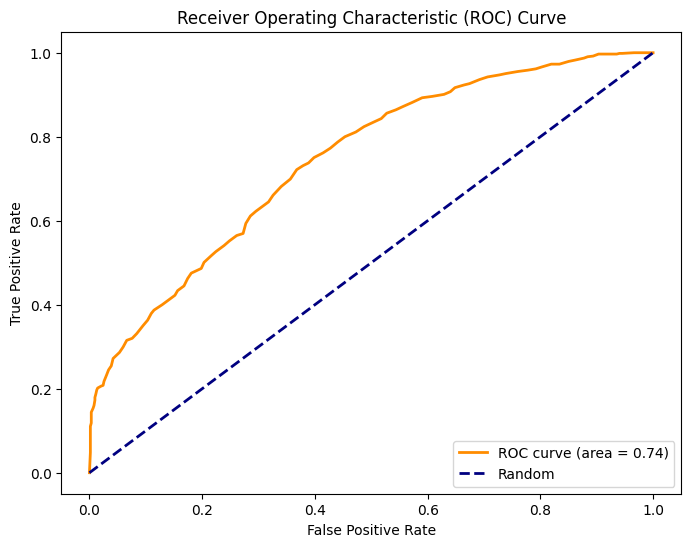

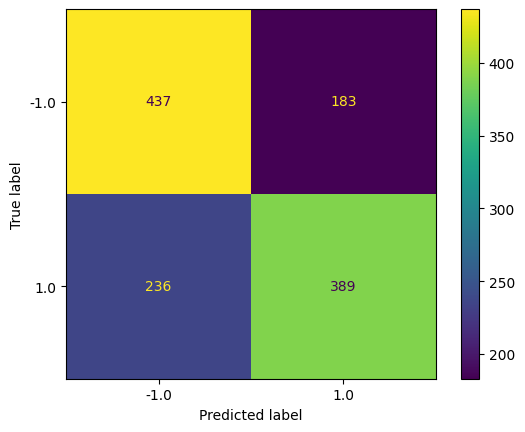

k_percent_14              0.195425
RSI_14                    0.185239
r_percent_14              0.185115
MACD                      0.153623
Price_Rate_Of_Change_9    0.152846
on_balance_volume         0.127752
dtype: float64

In [50]:
plot_roc_curve(rand_frst_clf, X_test, y_test)
plot_confusion_matrix(rand_frst_clf, X_test, y_test)
calculate_featuer_importances(rand_frst_clf, X_Cols)


### Random Forest + Randomized Search

In [51]:
# n_estimators = list(range(50, 2000, 50))
n_estimators = list(range(200, 2000, 100))
max_features = ['auto', 'sqrt', None, 'log2']
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10, 20, 30, 40]
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

Correct Prediction (%):  67.30923694779116


#### Visualisation

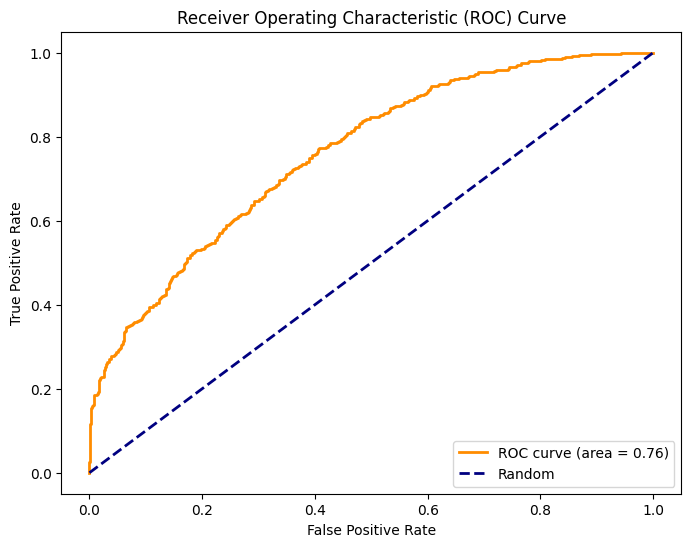

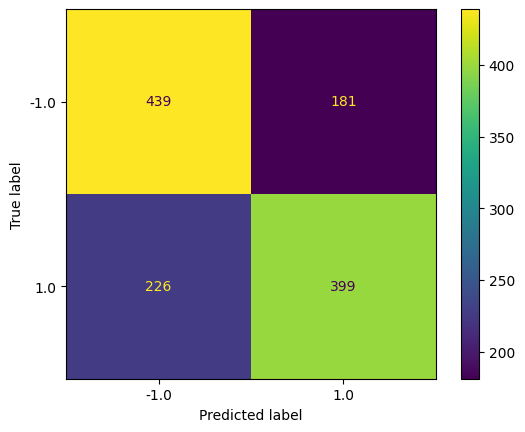

In [52]:
plot_roc_curve(rf_random, X_test, y_test)
plot_confusion_matrix(rf_random, X_test, y_test)

### AdaBoost

In [53]:
base_classifier = DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)
ada_boost.fit(X_train, y_train)
y_pred = ada_boost.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, ada_boost.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  69.07630522088354


#### Visualisation

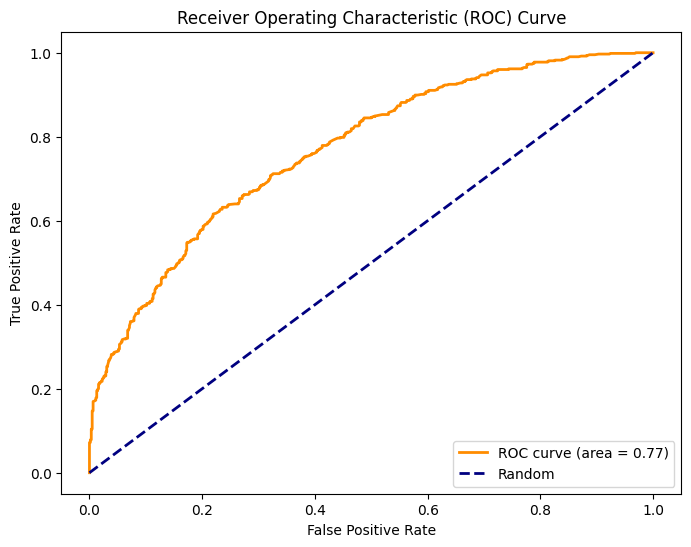

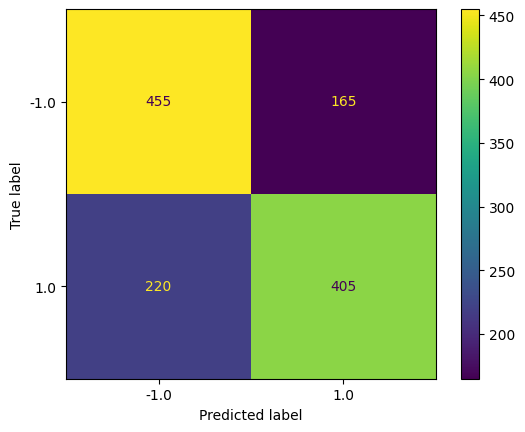

RSI_14                    0.30
k_percent_14              0.18
r_percent_14              0.18
Price_Rate_Of_Change_9    0.14
MACD                      0.12
on_balance_volume         0.08
dtype: float64

In [54]:
plot_roc_curve(ada_boost, X_test, y_test)
plot_confusion_matrix(ada_boost, X_test, y_test)
calculate_featuer_importances(ada_boost, X_Cols)

### AdaBoost + Randomized Search

In [56]:
my_list = np.logspace(-2, 0, num=100, endpoint=True)
my_list = [round(x, 2) for x in my_list]
my_list = list(set(my_list))

param_dist = {
    'base_estimator__max_depth': list(range(1, 21, 1)),
    'n_estimators': list(range(10, 300, 10)),
    'learning_rate': my_list
}

base_classifier = DecisionTreeClassifier()
ada_boost = AdaBoostClassifier(base_classifier)

ada_boost_random = RandomizedSearchCV(ada_boost, param_distributions=param_dist, n_iter=50, cv=3, random_state=42, n_jobs = -1)
ada_boost_random.fit(X_train, y_train)

print('Correct Prediction (%): ', accuracy_score(y_test, ada_boost_random.predict(X_test), normalize = True) * 100.0)

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:930: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  self.best_estimator_ = clone(base_estimator).set_params(


Correct Prediction (%):  68.67469879518072


#### Visualisation

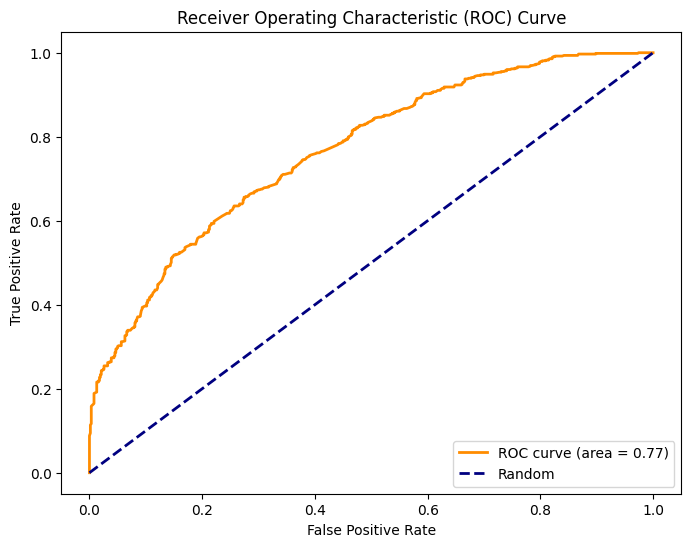

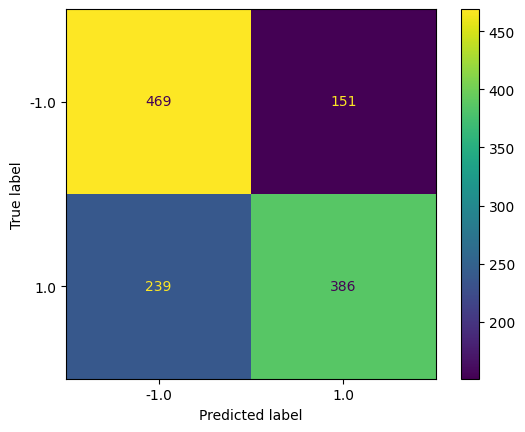

In [57]:
plot_roc_curve(ada_boost_random, X_test, y_test)
plot_confusion_matrix(ada_boost_random, X_test, y_test)


## Save models

In [ ]:
with open('adaboost_random.pkl', 'wb') as model_file:
    pickle.dump(ada_boost_random, model_file)